In [ ]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import skexplain
from skexplain.common.contrib_utils import get_indices_based_on_performance, avg_and_sort_contributions
from skexplain.common.importance_utils import to_skexplain_importance
# import plotting_config ## 只对例子数据有用
import sklearn
from sklearn.model_selection import train_test_split
import shap
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## my model 
# single data set to make model ~30 min
# use precomputed features, fit outlier detection model
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np

from multiprocessing import Pool
import time, os
from tqdm import tqdm

from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import pickle
import random
import seaborn as sns
# run_mymethod.py
from sklearn.neighbors import LocalOutlierFactor

import time, sys, os
import numpy as np
import pandas as pd
from scipy.stats import rankdata
from scipy.stats import spearmanr
import os


In [289]:
! conda install openpyxl -y

343980.61s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /mnt/disk7t/xwj/soft/miniforge3/envs/py3.10_skexplain

  added / updated specs:
    - openpyxl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    et_xmlfile-2.0.0           |     pyhd8ed1ab_1          21 KB  conda-forge
    openpyxl-3.1.5             |  py310h05b0c27_2         571 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         593 KB

The following NEW packages will be INSTALLED:

  et_xmlfile         conda-forge/noarch::et_xmlfile-2.0.0-pyhd8ed1ab_1 
  openpyx

In [2]:
! conda list scikit-explain

# packages in environment at /mnt/disk7t/xwj/soft/miniforge3/envs/py3.10_skexplain:
#
# Name                    Version                   Build  Channel
scikit-explain            0.1.4              pyhd8ed1ab_0    conda-forge


osg_p  ord_p_devi
Gene                             
A2M  M13-1   2.040221    0.127198
     M13-7   1.634756    0.373048
     M13-16  0.967584    0.204636
     M13-18  6.055761    2.252840
     M13-23  0.156654    0.499555
...               ...         ...
ZZZ3 UC98    0.134675    0.063346
     UC50    1.067114    0.181122
     UC129   1.414694    0.691720
     UC77    0.225647    0.174634
     UC357   0.052346    0.281686

[488628 rows x 2 columns]

In [ ]:


def get_cts(X, normalization):
    # normalization : ['none', 'outriderAE','quantilenorm']
    if normalization == 'none':
        cts = X[ 'raw' ]
    elif normalization == 'outriderAE':
        cts =  X[ 'outriderNormCts' ]
    elif normalization == 'quantilenorm':
        cts = X['raw'].copy()
        cts.loc[:,:] = _quantile_normalize(cts)
    else:
        print('invalid normalization:', normalization)
        pass
    return cts
    
def zscore(df, zscore_type):
    if zscore_type == 'count':
        df_zscore = df.transform(lambda x: (x-x.mean())/x.std(), axis=1) 
    elif zscore_type == 'rank':
        df_zscore = df.rank(axis=0).transform(lambda x: (x-x.mean())/x.std(), axis=1).fillna(value=0)
    else:
        print('other zscore?', zscore_type)
    return df_zscore.astype( np.float64 )

def corrmat(df, corr_method):
    if corr_method == 'pearson':
        corr = np.corrcoef(df)
    elif corr_method == 'spearman':
        corr, _ = spearmanr(df.T)
    else:
        pass
    
    if (corr == 0).sum().sum() > 0:
        # 创建一个与corr形状相同的掩码，标记所有0的位置
        mask = (corr == 0)
        # 生成与0值数量相同的随机数
        random_values = np.random.uniform(low=0, high=1e-3, size=mask.sum())
        # 使用掩码一次性替换所有0值
        corr[mask] = random_values

    corr = pd.DataFrame(corr, index=df.index.tolist(), columns=df.index.tolist()).astype(np.float64)
    np.fill_diagonal(corr.values, 0)
    return corr

# 计算devi新指标,mode参数用来选择版本
def devi(f, corr, df_zscore, window_size, mode, g):
    # gene 
    g_pearson = corr[g]
    z_self = df_zscore.loc[g,:]
    
    ## average z score of co-express genes
    mean_z_positive_corr_gene = df_zscore.loc[g_pearson.nlargest(window_size).sort_values(ascending=False).index,:].mean()   
    mean_z_negative_corr_gene = df_zscore.loc[g_pearson.nsmallest(window_size).sort_values(ascending=True).index,:].mean()
    
    # v1
    if mode == 0: # 新，正负相关基因都参考
        return f( mean_z_positive_corr_gene - z_self) + f( mean_z_negative_corr_gene + z_self)
    elif mode == 1: # 原始，只参考一组正相关基因
        return f( mean_z_positive_corr_gene - z_self)
    else:
        return 0
    
# Outlier detection: single gene per loop
#---------------#
def load_x(path_outsingle, path_outrider):
    result_baseline = {
        # p-value of outsingle
        'outsingleP': path_outsingle, 
        # p-value of outrider
        'outriderP': path_outrider,
    }

    file = result_baseline['outriderP']
    # other files are infered from the filepath of outriderP 
    # 4. AE-normalized counts of outrider
    result_baseline['outriderNormCts'] =f'{file}_normcounts.gz'
    # 5. Zscore after AE-norm of outrider
    result_baseline['outriderCtsZ'] = f'{file}_zScore.gz'
    result_baseline['outriderP'] = f'{file}_pValue.gz' # use p-values ？？
    print(result_baseline)

    features = ['outsingleP','outriderP','outriderCtsZ','outriderRankZ','outriderNormCts']
    X = dict.fromkeys(features)
    data = pd.read_csv(result_baseline['outsingleP'], sep='\t',index_col=0)
    X['outsingleP'] = -np.log(data)
    data = pd.read_csv(result_baseline['outriderP'], sep='\t',index_col=0)
    X['outriderP'] = - np.log(data)

    X['outriderCtsZ'] = pd.read_csv(result_baseline['outriderCtsZ'], sep='\t',index_col=0)
    X['outriderNormCts'] = pd.read_csv(result_baseline['outriderNormCts'], sep='\t',index_col=0)

    n_gene = X['outriderNormCts'].shape[0]

    nt,zscore_type,cm, pct_x, mode, score = 'outriderAE', 'count', 'pearson', 0.1, 1, 'outriderP'
    window_size = int(pct_x*n_gene//100)

    key = ( nt, zscore_type, cm, window_size, mode, score)
    print(key)
    cts = get_cts(X, normalization=nt)
    df_zscore = zscore(cts, zscore_type)
    corr = corrmat(df_zscore, cm)
    genes = df_zscore.index
    res_list = [ devi(abs, corr, X[score], window_size, mode, g) for g in genes ]
    print(len(res_list) )
    df_devi = pd.concat( res_list, axis=1, keys=genes )
    X[ key ] = df_devi.copy().T
    Xsmall = pd.concat( [ X[f].stack() for f in ['outsingleP', key] ], axis=1, keys = [ 'osg_p','ord_p_devi' ])
    return Xsmall


#---------------#


def get_feature_importance(Xsmall, list_gene_symbols):
    
    features = Xsmall.columns #['rank_devi', 'cts_devi', 'cts_z', 'rank_z', 'osg_pv']
    df_feature_importance = pd.DataFrame( data = 0,
        index = pd.MultiIndex.from_product([ ['shap','lime'], features], names = ['ex', 'feature'] ),
        columns =  list_gene_symbols )

    # explain on individual gene specific model
    for g in list_gene_symbols:
        Xg = Xsmall.loc[g]
        print(g, Xsmall.shape, Xg.shape)
        my_estimators = ('LOF', LocalOutlierFactor(n_neighbors=20, contamination="auto", novelty=True).fit(Xg))

        lime_kws = {'training_data' : Xg.values} # For the LIME, must provide the training dataset
        shap_kws = {'masker' : shap.maskers.Partition(Xg, max_samples=100, clustering="correlation"), 
                    } # 'algorithm' : 'permutation'
        explainer = skexplain.ExplainToolkit(my_estimators, X= Xg,)
        results = explainer.local_attributions(method=['shap', 'lime', ],
                                            shap_kws=shap_kws,
                                            lime_kws=lime_kws,)
        
        # Convert the shap values to importance scores for plotting.
        # For SHAP values, we can use the 'shap_sum' or 'shap_std' methods available
        # in to_skexplain_importance.
        shap_rank = to_skexplain_importance(results['shap_values__LOF'].values, estimator_name='LOF', feature_names=features, method='shap_sum')
        lime_rank = to_skexplain_importance(results['lime_values__LOF'].values, estimator_name='LOF', feature_names=features, method='lime')
        
        df_feature_importance.loc[ ('shap', (shap_rank['shap_sum_rankings__LOF'].values)), g ] = shap_rank['shap_sum_scores__LOF'].values
        df_feature_importance.loc[ ('lime', (lime_rank['lime_rankings__LOF'].values)), g ] = lime_rank['lime_scores__LOF'].values
    return df_feature_importance


In [ ]:
workdir = '/mnt/disk7t/xwj/axolotl_rev/'
# os.mkdir(f'{workdir}/result/explain_model')
os.system(f'mkdir -p {workdir}/result/explain_model')

dict_explain = dict()

# Kremer119, Pfibns154 and Pfibss269
for dataset in ['pfibns154','pfibss269','kremer119','pmuscle36',]:
    dict_explain[dataset] = dict()
    if dataset == 'pmuscle36': # 13k gene min 10 reads
        
        use = dataset
        output_path = f'{workdir}/result/dataset_pmuscle_36'
        datasetdir = f'{workdir}/pmuscle_36_processed' 

        tissues = pd.read_csv(f'{datasetdir}/tissues_{use}.tsv', sep='\t', index_col=0)
        ctsfile = tissues.loc[0,'CTS_FILE']
        cts = pd.read_csv(ctsfile, sep='\t', index_col=0)
        outlierfile = tissues.loc[0,'OUTLIER_FILE']
        outlier = pd.read_csv(outlierfile, sep='\t', index_col=0)
        my_genes = outlier['Gene'].unique().tolist()
        my_genes = ['COL6A1','COL6A2','COL6A3',] 
        other_genes = ['COL6A6','CAPN3', 'DYSF','TTN','TCAP','LMNA']
        
    if dataset == 'kremer119': 
        
        use = 't00_FB_s119_g14409'
        datasetdir = f'{workdir}/dataset_nc2017kremer'
        output_path = f'{workdir}/result/dataset_nc2017kremer'

        tissues = pd.read_csv(f'{datasetdir}/tissues_{use}.tsv', sep='\t', index_col=0)
        ctsfile = tissues.loc[0,'CTS_FILE']
        cts = pd.read_csv(ctsfile, sep='\t', index_col=0)
        outlierfile = tissues.loc[0,'OUTLIER_FILE']
        outlier = pd.read_csv(outlierfile, sep='\t', index_col=0)
        my_genes = outlier['Gene'].unique().tolist()
        other_genes = []
        
    if (dataset == 'pfibns154') or (dataset == 'pfibss269'):
        # result/dataset_pfib_423_split/task_config/t00_FBSS_s269_g12369.config
        # result/dataset_pfib_423_split/task_config/t01_FBNS_s154_g13411.config
        use = 'split'
        datadir = '/mnt/disk7t/xwj/axolotl_rev/pfib_423_processed/'
        output_path = f'{workdir}/result/dataset_pfib_423_split'
        
        tissues = pd.read_csv(f'{datadir}/tissues_{use}.tsv', sep='\t', index_col=0)
        if dataset == 'pfibns154':
            ctsfile = tissues.loc[1,'CTS_FILE']
            outlierfile = tissues.loc[1,'OUTLIER_FILE']
            tissues = tissues.tail(1)
        if dataset == 'pfibss269': 
            ctsfile = tissues.loc[0,'CTS_FILE']
            outlierfile = tissues.loc[0,'OUTLIER_FILE']
            tissues = tissues.head(1)
        cts = pd.read_csv(ctsfile, sep='\t', index_col=0)
        outlier = pd.read_csv(outlierfile, sep='\t', index_col=0)
        my_genes = outlier['Gene'].unique().tolist()
        other_genes = []
        
    all_genes = [ g for g in cts.index.tolist() if (g not in my_genes) & (g not in other_genes) ]
    other_genes = random.sample(all_genes, 100-len(other_genes)) + other_genes
    list_gene_symbols = other_genes + my_genes
   
    dict_explain[dataset]['my_genes'] = my_genes
    dict_explain[dataset]['other'] = other_genes
    dict_explain[dataset]['outlier'] = outlier

    print(f'{dataset}, Number of genes for explanation: {len(list_gene_symbols)}')
    # print(tissues)
    # level 2    
    samples_path = f'{output_path}/samples'
    task_config_path = f'{output_path}/task_config'
    task_output_path = f'{output_path}/task_output'
    metric_output_path = f'{output_path}/metric'
    
    for i, row in tissues.iterrows():
        # --> level 1. one tissue
        t  = row.TISSUE_ID
        tn = row.TISSUE_NAME
        ns = row.N_SAMPLE
        ng = row.N_GENE
        ctsfile = row.CTS_FILE
        outlierfile = row.OUTLIER_FILE
        
        # 创建基础前缀
        prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
        
        # positive samples
        outlier = pd.read_csv(outlierfile, sep='\t', index_col=0)
        
        task_config = pd.read_csv(f'{task_config_path}/{prefix}.config', sep='\t')

        ### 
        for j,row in task_config.iterrows():
            # for all datasets 
            Xsmall = load_x(row['OUTSINGLE'], row['OUTRIDER'])
            dict_explain[dataset]['feature'] = Xsmall # save to plot distribution
            if False:
                df_feature_importance = get_feature_importance(Xsmall, list_gene_symbols)
                file = f'{workdir}/result/explain_model/{dataset}_feature_importance.txt'
                df_feature_importance.to_csv(file, sep='\t', index=True)


pfibns154, Number of genes for explanation: 121
{'outsingleP': '/mnt/disk7t/xwj/axolotl_rev//result/dataset_pfib_423_split/task_output/t01_FBNS_s154_g13411/000_outsingle.txt.gz', 'outriderP': '/mnt/disk7t/xwj/axolotl_rev//result/dataset_pfib_423_split/task_output/t01_FBNS_s154_g13411/000_outrider.txt.gz_pValue.gz', 'outriderNormCts': '/mnt/disk7t/xwj/axolotl_rev//result/dataset_pfib_423_split/task_output/t01_FBNS_s154_g13411/000_outrider.txt.gz_normcounts.gz', 'outriderCtsZ': '/mnt/disk7t/xwj/axolotl_rev//result/dataset_pfib_423_split/task_output/t01_FBNS_s154_g13411/000_outrider.txt.gz_zScore.gz'}
('outriderAE', 'count', 'pearson', 13, 1, 'outriderP')
13411
pfibss269, Number of genes for explanation: 125
{'outsingleP': '/mnt/disk7t/xwj/axolotl_rev//result/dataset_pfib_423_split/task_output/t00_FBSS_s269_g12369/000_outsingle.txt.gz', 'outriderP': '/mnt/disk7t/xwj/axolotl_rev//result/dataset_pfib_423_split/task_output/t00_FBSS_s269_g12369/000_outrider.txt.gz_pValue.gz', 'outriderNormCts

In [290]:
# the genes used in explain analysis
genes_table = pd.concat( [
    pd.DataFrame([ dict_explain[dataset]['my_genes'] for dataset in list_datasets ], index=list_datasets).T,
    pd.DataFrame([ dict_explain[dataset]['other'] for dataset in list_datasets ], index=list_datasets).T], keys=['my_genes','other'], names=['group',] )
genes_table.to_excel(f'{workdir}/result/explain_model/s7_explain_genes.xlsx', 
                            sheet_name='s7_explain_genes',index=True)

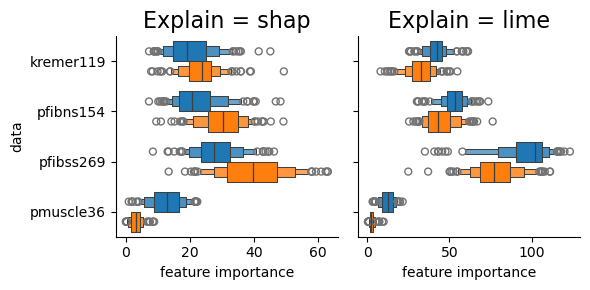

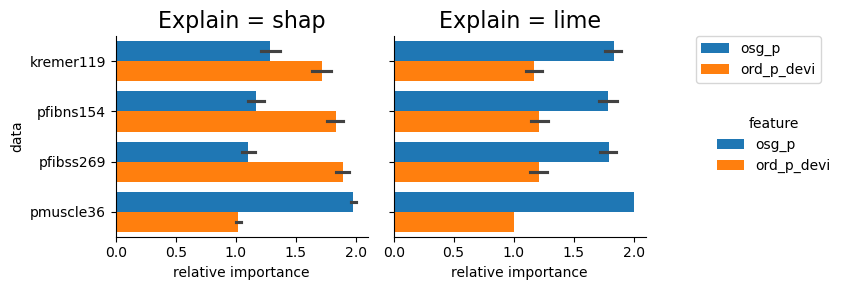

In [ ]:
# plot
list_datasets = ['pfibns154','pfibss269','kremer119','pmuscle36',]    
draw = pd.concat([ pd.read_csv(f'{workdir}/result/explain_model/{dataset}_feature_importance.txt', sep='\t',index_col=[0,1]) 
                  for dataset in list_datasets] , axis=1, keys= list_datasets)

draw2 = draw\
    .stack(level=[0,1]).reset_index().rename(columns={0:'feature importance','level_2':'data','ex':'Explain'})
plt.style.use('default')
g=sns.catplot(data=draw2, kind='boxen', 
              x = 'feature importance',hue='feature', col='Explain', y='data',
              sharex='col', saturation=1, alpha = 1, sharey=True, palette='tab10', legend=False, height=3, aspect=1)
g.despine(bottom=False, left=False)
g.set_titles(size=16)   
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/explain_box_importance.pdf',dpi=200,)

draw1 = draw.groupby(level=[0]).rank().stack(level=[0,1]).reset_index().rename(columns={0:'feature importance','level_2':'data','ex':'Explain'})
g = sns.catplot(data=draw1, kind='bar',
            col='Explain', x='feature importance',hue='feature',
            y='data',
            saturation=1, linewidth=1, margin_titles=False, palette='tab10',
            height=3, aspect=1.2)
g.set_axis_labels("relative importance")
g.set_titles(size=16)   
# # g.set_titles("{col_name}: {col_var}")
# # g.set(yticks=[5,4,3,2,1])
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/explain_bar_relative_importance.pdf',dpi=200,)

In [ ]:
# raw features to explain
draw = pd.concat( [ dict_explain[dataset]['feature'] for dataset in list_datasets ], keys=list_datasets, names=['dataset', 'gene', 'sample'] )

for dataset in list_datasets:
    # outlier
    outlier = dict_explain[dataset]['outlier'].copy()
    for idx, row in outlier.iterrows():
        g = row['Gene']
        s = row['Sample']
        draw.loc[(dataset,g,s), 'group' ] = 'outlier'
        
    the_same_samples = outlier['Sample'].unique().tolist()
    other_genes = dict_explain[dataset]['other']
    
    # other
    draw.loc[(dataset,other_genes,the_same_samples), 'group' ] = 'other'
print(draw['group'].value_counts())
draw = draw.dropna(subset=['group'])
draw

group
other      9800
outlier      99
Name: count, dtype: int64


osg_p  ord_p_devi  group
dataset   gene   sample                             
pfibns154 AASS   R30525  0.091019    0.308812  other
                 R47816  0.555126    0.196393  other
                 R34820  1.177655    1.056159  other
                 R52016  0.774357    0.671351  other
                 R26710  1.374366    0.068471  other
...                           ...         ...    ...
pmuscle36 ZNHIT2 UC98    0.220647    0.070788  other
                 UC50    0.297059    0.188312  other
                 UC129   0.199671    0.596049  other
                 UC77    0.765718    0.383339  other
                 UC357   0.037702    0.249827  other

[9899 rows x 3 columns]

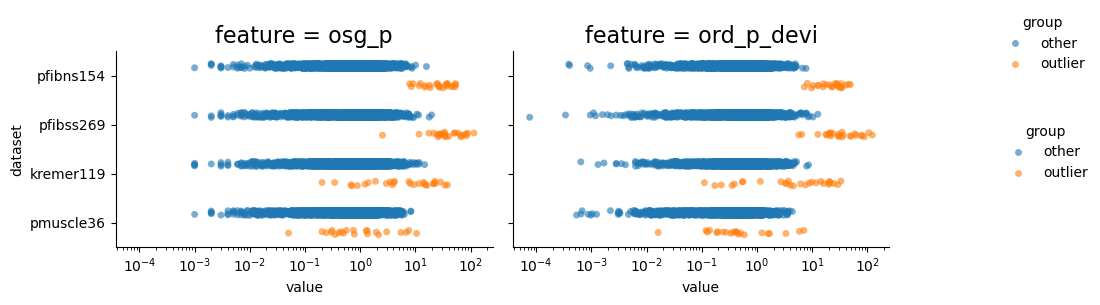

In [264]:
draw_long = draw.set_index(['group'], append=True).stack().reset_index().rename(columns = {'level_4':'feature', 0:'value'})
g = sns.catplot(data=draw_long, kind='strip',
            x='value',hue='group', col='feature', y='dataset',
            # inner=None,split=True,# for violin
            dodge=True, linewidth=0, alpha=.6, size=5, log_scale=True, # strip
            saturation=1, palette='tab10',
            height=3, aspect=1.2, legend=True)
g.set_titles(size=16)   
# plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', )
g.add_legend(title='group',
             bbox_to_anchor=(1.1, 1),
             loc='upper left',
             borderaxespad=0)
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/explain_scatter_features.pdf',dpi=200,)
